In [1]:
import os
import sys

# Get current working directory and append parent directory to path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
main_compute_device = 'gpu'

import pandas as pd
import numpy as np
import jax
import jax.numpy as jnp
jax.config.update("jax_enable_x64", True)

from orig.tl_parafac_fix_intercept import parafac_fix_intercept
from orig.utils_tensor import get_normalized_factors
from tfm.parafac_jax import parafac_enhanced, normalize_factors
from tfm.models.tensor import Tensor_Multiperiod_Unmapped
max_lag = 60
idx_window = 1
window_size = 60
K = 20
dir_input = '/home/james/projects/tsfc/code/code_11092024/organized_data/organized_data/char_anom'
old_dir_out = '/home/james/projects/tsfc/code/code_11092024/results_oos/multiperiod/char_anom/fig_onefit_oos_ret_rankptf_OLD/'
new_dir_out = '/home/james/projects/tsfc/code/code_11092024/results_oos/multiperiod/char_anom/fig_onefit_oos_ret_rankptf_ver1/'

X = jnp.load(f'{dir_input}/mat_ptf_re_lag_{max_lag}.npz')['mat_ptf_re_rank']
params = jnp.load(f'{dir_input}/dict_param_lag_{max_lag}.pkl', allow_pickle=True)
bin_labels, all_dates = params['lst_char'], params['all_dates']
T = len(all_dates)
start_date_oos = pd.to_datetime('2000-01-01')
start_date = all_dates[0]
dates_fit = all_dates[all_dates < start_date_oos]
dates_oos = all_dates[all_dates >= start_date_oos]
T_fit = len(dates_fit)
T_oos = len(dates_oos)
num_ptf = X.shape[2]

X_log = jnp.log(1 + X)
assert not jnp.isnan(X_log).any()

ModuleNotFoundError: No module named 'tensorly'

In [2]:
calc_types = ['approx']

def old(X_log, idx_window, K, window_size, random_seed = 100,
        n_iter_max = 100, max_horizon = 36):
    X_fit=X_log[idx_window:idx_window+window_size]
    
    # fit tensor model using all data in the rolling window
    decomp= parafac_fix_intercept(X_fit,
            rank=K, 
            verbose=False,
            random_state=np.random.RandomState(random_seed),
                                return_errors=False,
                                n_iter_max=n_iter_max,)

    dict_fit=dict(zip(['F','W','B'], decomp.factors))
    dict_fit['S']=decomp.weights
    dict_fit = get_normalized_factors(dict_fit, reorder=True)
    F, W, B, S=[dict_fit[key] for key in ['F','W','B','S']]

    # get F_next for the next max_horizon periods by regressing X_next on tensor loadings
    F_next=np.full((max_horizon, K), np.nan)
    for idx_h in range(max_horizon):
        X_next=X_log[idx_window+window_size+idx_h]
        X_next_flatten=X_next.reshape(1,-1)
        Z_fit=np.full((K,num_ptf*max_lag),np.nan)
        for i in range(K):
            Z_fit[i]=np.kron(W[:,i], B[:,i])*S[i]
        mat_weight_flatten=Z_fit.T@np.linalg.inv(Z_fit@Z_fit.T) # dim: (num_char*max_lag, K+1)
        F_next[idx_h,:]=X_next_flatten@mat_weight_flatten

    # get approx multiperiod return in the window
    FW=np.full((K, window_size, max_lag), np.nan)
    for idx_k in range(K):
        FW[idx_k]=(F[:,idx_k][:,np.newaxis]@W[:,idx_k][np.newaxis,:]).cumsum(axis=1)


    ### calc mean and covariance of multi-horizon factor returns to get mean-variance weight
    dict_mv={}

    ##  1. approx calc
    mu_FW=np.mean(FW, axis=1).T # dim: (max_lag, K)
    # note that FW has no time-series correlation in approx calc, because cumsum is over dimension W, not over F
    cov_FW=np.full((max_lag, K, K),np.nan)
    for idx_s in range(max_lag):
        s = idx_s+1
        # if fit_rx and idx_s==0:
        #     continue
        cov_FW[idx_s]=np.cov(FW[:,:,idx_s],bias=True)
    dict_mv['approx'] = {'mu_FW':mu_FW, 'cov_FW':cov_FW}


    # get oos multi-horizon return FW
    FW_next = (F_next*W[:max_horizon,:]).cumsum(axis=0) # is this right ????

    # get MV weights on multiperiod factor FW, and ptf return
    for calc_type in calc_types:
        mu_FW, cov_FW = dict_mv[calc_type]['mu_FW'], dict_mv[calc_type]['cov_FW']
        mv_weight=np.full((max_horizon, K), np.nan)
        for idx_s in range(max_horizon):
            # if fit_rx and idx_s==0:
            #     continue
            #print(calc_type, idx_s, cov_FW[idx_s])
            mv_weight[idx_s]=np.linalg.inv(cov_FW[idx_s])@mu_FW[idx_s]
        # dict_mat_ret_tensor_oos[calc_type][idx_window, :, idx_K] =\
    
    return (FW_next* mv_weight[:max_horizon]).sum(axis=1) # dim: (max_horizon, )

In [3]:
new = jnp.load(new_dir_out + 'dict_tensor_oos_optimized.pkl', allow_pickle=True)

In [4]:
lst = []
L = 11
for i in range(L):
    temp = old(X_log, i, K, window_size)
    temp = jnp.expand_dims(temp, axis=-1)
    lst.append(temp)

seq = jnp.concatenate(lst, axis=-1)

In [5]:
K, window_size

(20, 60)

In [6]:
new.keys()

dict_keys([60, 120])

In [7]:
seq.T[4]

Array([-1.3349541e+00,  3.6853433e-01,  3.3507890e-01, -4.9616575e-01,
        3.7276575e-01,  8.4855175e-01,  9.6165752e-01,  2.1397866e-01,
       -8.8795424e-01,  4.1079393e-01, -9.6443672e+00, -1.8288480e-01,
        1.4702832e+00,  1.3385253e+00,  1.3714052e+00,  1.4346644e+00,
        1.4810275e+00,  1.4457437e+00,  1.5599165e+00,  1.6316236e+00,
        1.2942131e+00, -4.9287090e+00,  3.9752362e+00,  8.5711555e+00,
        1.5549891e+01,  2.4268867e+01, -2.7291632e+02, -5.7939484e+01,
       -1.6048906e+01, -9.8058891e+00, -7.5926013e+00, -6.9684353e+00,
       -7.4672804e+00, -9.6622257e+00, -1.2162379e+01, -8.8596115e+01],      dtype=float32)

In [8]:
new[60][4, :, -1]

Array([-1.3349389e+00,  3.6813077e-01,  3.3489838e-01, -4.9620938e-01,
        3.7265015e-01,  8.4840727e-01,  9.6153879e-01,  2.1371175e-01,
       -8.8916260e-01,  4.1158691e-01, -9.5335531e+00, -1.8255793e-01,
        1.4682800e+00,  1.3370101e+00,  1.3701856e+00,  1.4335983e+00,
        1.4801532e+00,  1.4449241e+00,  1.5590581e+00,  1.6308141e+00,
        1.2937171e+00, -4.9171309e+00,  3.9788573e+00,  8.5723782e+00,
        1.5548090e+01,  2.4266630e+01, -2.7306271e+02, -5.8435165e+01,
       -1.6066479e+01, -9.8093634e+00, -7.5936513e+00, -6.9689083e+00,
       -7.4675107e+00, -9.6623535e+00, -1.2163073e+01, -8.8588608e+01],      dtype=float32)

In [9]:
jnp.allclose(new[60][:3, :, -1], seq.T[:3])

Array(False, dtype=bool)

In [10]:
in_axes = (None, 0, None, None)
Tensor_Multiperiod = jax.vmap(Tensor_Multiperiod_Unmapped, in_axes=in_axes)

In [11]:
tensor_60_3 = new[60][:, :, 1]

In [12]:
tensor_60_3.shape

(424, 36)

In [15]:
%%time
x = Tensor_Multiperiod(X_log, jnp.arange(X_log.shape[0] - window_size - 36 + 1), 20, 60)
jax.block_until_ready(x)


CPU times: user 4.8 s, sys: 127 ms, total: 4.92 s
Wall time: 4.97 s


Array([[-4.4392574e-01,  2.8304763e+00,  4.7116256e-01, ...,
        -3.1715355e+00,  1.1707858e+01,  5.6862860e+00],
       [ 8.4743814e+00,  1.7793362e+00,  9.1309586e+00, ...,
        -6.0000405e+00, -6.0443568e+00, -6.3594427e+00],
       [-3.9484682e+00, -1.3587877e+00, -2.1378655e+00, ...,
        -2.3015308e+02,  2.0515947e+02,  4.1206514e+03],
       ...,
       [ 1.4979670e+00, -1.0826215e+01,  3.9007926e-01, ...,
        -1.5199315e+01,  3.5324092e+00, -8.9921695e-01],
       [ 2.7198577e-01, -1.2873178e+00, -1.6364470e+00, ...,
        -2.6805952e+01,  2.5478685e+01, -2.7557111e+02],
       [-2.8020568e+00, -2.4098577e+00, -1.9551715e+00, ...,
         3.6933556e+01,  5.4001884e+00,  1.0860498e-01]], dtype=float32)

### OOS Sharpe Ratio Plot

In [15]:
dataset = 'scs'
import jax.numpy as jnp

In [16]:
dir_in = f'/home/james/projects/tsfc/code/code_11092024/results_oos/multiperiod/{dataset}/fig_oos_ret_rankptf_ver2/'
# dir_out = f'/home/james/projects/tsfc/code/code_11092024/results_oos/multiperiod/{dataset}/fig'
new = jnp.load(dir_in + 'dict_tensor_oos.pkl', allow_pickle=True)

# Plot 1

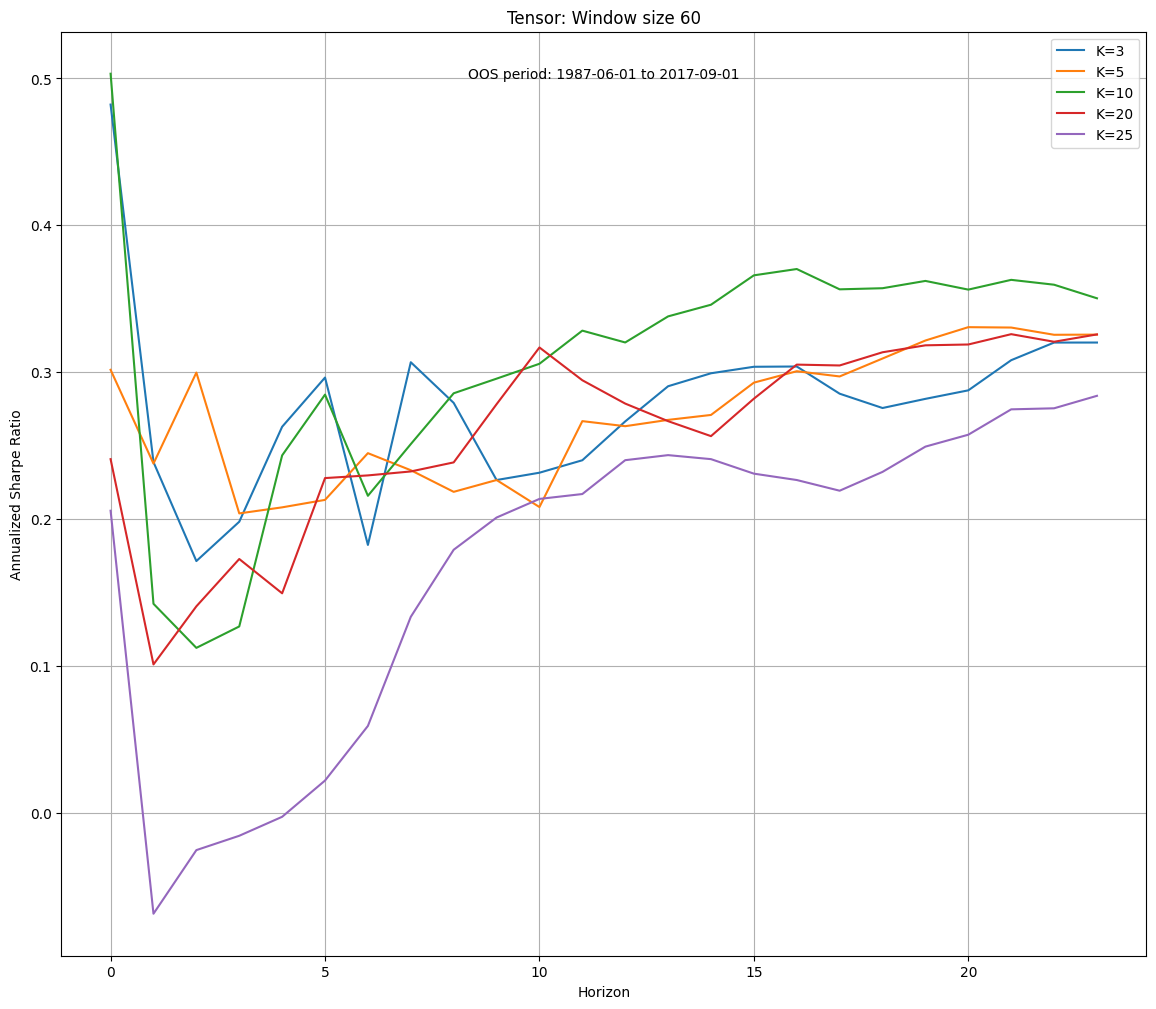

In [18]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

# lst_window_size = [6, 12, 24, 36]
# w1, w2, w3, w4 = lst_window_size
w1 = 60
max_horizon = 24

sr_60 = new[w1].mean(axis=0) / new[w1].std(axis=0)

lst_K = [3, 5, 10, 20, 25]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(1, 1, figsize=(14, 12))

# Plot for window size 60
axes.set_title(f'Tensor: Window size {w1}')
axes.text(0.5, 0.95, 'OOS period: 1987-06-01 to 2017-09-01', 
            transform=axes.transAxes, ha='center', fontsize=10)
for i in range(len(lst_K)):
    sr_oos_60 = sr_60[:, i] * jnp.sqrt(1 / jnp.arange(1, 1 + max_horizon)) * jnp.sqrt(12)
    axes.plot(sr_oos_60, linestyle='-', label=f'K={lst_K[i]}')
axes.set_xlabel('Horizon')
axes.set_ylabel('Annualized Sharpe Ratio')
axes.legend()
axes.grid(True)

filename = f'oos_sr_multiperiod_ver2_dailylag'
fig.savefig(f'{dir_in}{filename}', bbox_inches='tight')

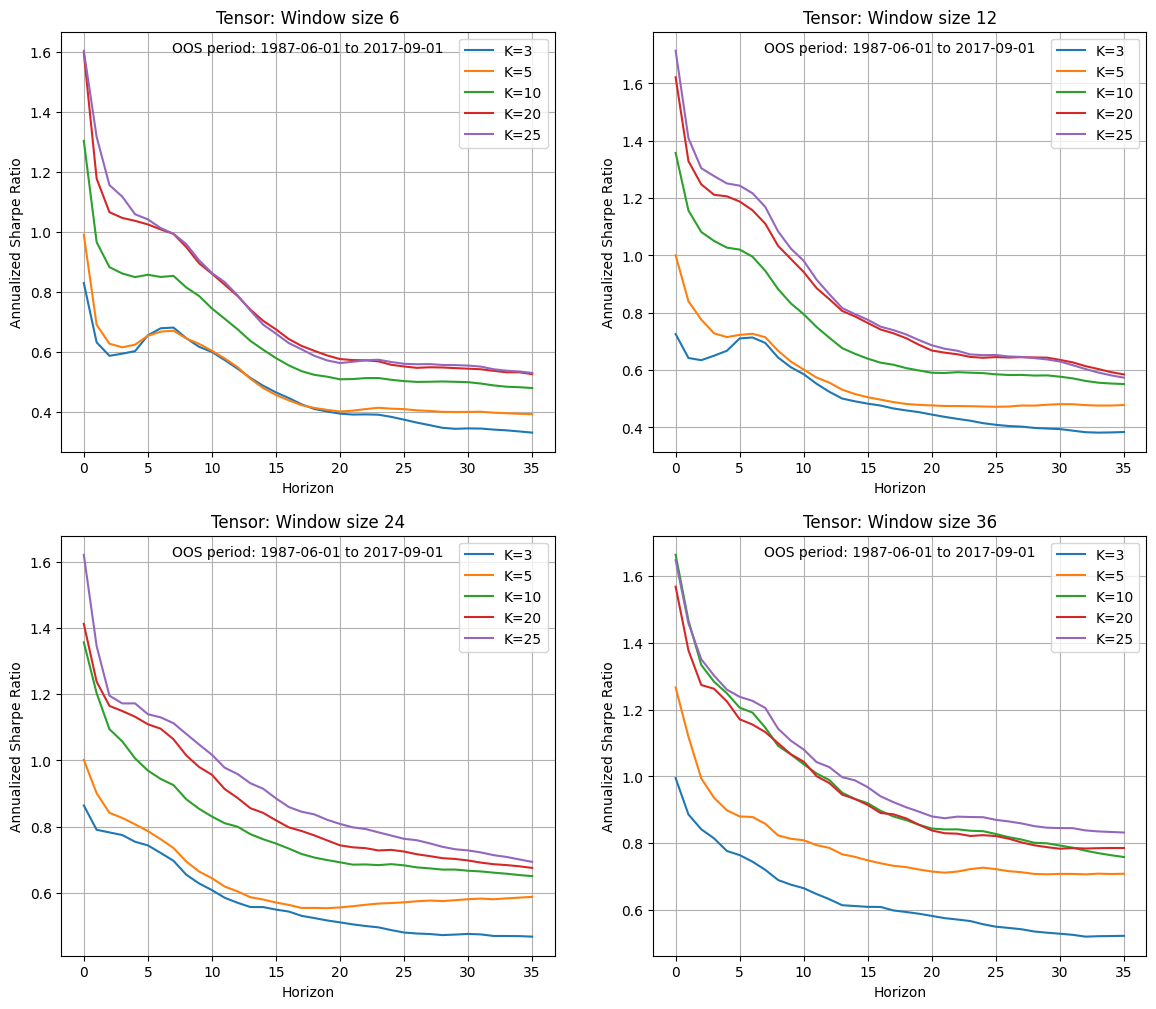

In [8]:
import matplotlib.pyplot as plt
import jax.numpy as jnp

lst_window_size = [6, 12, 24, 36]
w1, w2, w3, w4 = lst_window_size
max_horizon=36

sr_60 = new[w1].mean(axis=0) / new[w1].std(axis=0)
sr_120 = new[w2].mean(axis=0) / new[w2].std(axis=0)
sr_240 = new[w3].mean(axis=0) / new[w3].std(axis=0)
sr_360 = new[w4].mean(axis=0) / new[w4].std(axis=0)

lst_K = [3, 5, 10, 20, 25]

# Create a figure with two subplots side by side
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot for window size 60
axes[0][0].set_title(f'Tensor: Window size {w1}')
axes[0][0].text(0.5, 0.95, 'OOS period: 1987-06-01 to 2017-09-01', 
            transform=axes[0][0].transAxes, ha='center', fontsize=10)
for i in range(len(lst_K)):
    sr_oos_60 = sr_60[:, i] * jnp.sqrt(1 / jnp.arange(1, 1 + max_horizon)) * jnp.sqrt(12)
    axes[0][0].plot(sr_oos_60, linestyle='-', label=f'K={lst_K[i]}')
axes[0][0].set_xlabel('Horizon')
axes[0][0].set_ylabel('Annualized Sharpe Ratio')
axes[0][0].legend()
axes[0][0].grid(True)

# Plot for window size 120
axes[0][1].set_title(f'Tensor: Window size {w2}')
axes[0][1].text(0.5, 0.95, 'OOS period: 1987-06-01 to 2017-09-01', 
             transform=axes[0][1].transAxes, ha='center', fontsize=10)
for i in range(5):
    sr_oos_120 = sr_120[:, i] * jnp.sqrt(1 / jnp.arange(1, 1 + max_horizon)) * jnp.sqrt(12)
    axes[0][1].plot(sr_oos_120, linestyle='-', label=f'K={lst_K[i]}')
axes[0][1].set_xlabel('Horizon')
axes[0][1].set_ylabel('Annualized Sharpe Ratio')
axes[0][1].legend()
axes[0][1].grid(True)

# Plot for window size 240
axes[1][0].set_title(f'Tensor: Window size {w3}')
axes[1][0].text(0.5, 0.95, 'OOS period: 1987-06-01 to 2017-09-01', 
             transform=axes[1][0].transAxes, ha='center', fontsize=10)
for i in range(5):
    sr_oos_240 = sr_240[:, i] * jnp.sqrt(1 / jnp.arange(1, 1 + max_horizon)) * jnp.sqrt(12)
    axes[1][0].plot(sr_oos_240, linestyle='-', label=f'K={lst_K[i]}')
axes[1][0].set_xlabel('Horizon')
axes[1][0].set_ylabel('Annualized Sharpe Ratio')
axes[1][0].legend()
axes[1][0].grid(True)

# Plot for window size 360
axes[1][1].set_title(f'Tensor: Window size {w4}')
axes[1][1].text(0.5, 0.95, 'OOS period: 1987-06-01 to 2017-09-01', 
             transform=axes[1][1].transAxes, ha='center', fontsize=10)
for i in range(5):
    sr_oos_360 = sr_360[:, i] * jnp.sqrt(1 / jnp.arange(1, 1 + max_horizon)) * jnp.sqrt(12)
    axes[1][1].plot(sr_oos_360, linestyle='-', label=f'K={lst_K[i]}')
axes[1][1].set_xlabel('Horizon')
axes[1][1].set_ylabel('Annualized Sharpe Ratio')
axes[1][1].legend()
axes[1][1].grid(True)

filename = f'oos_sr_multiperiod_ver2_dailydata_shorthorizon'
fig.savefig(f'{dir_in}{filename}', bbox_inches='tight')